In [1]:
import os
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import cv2
import random
import time
from PIL import Image
import pandas as pd

In [2]:
# Library Constants
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkPoints = mp.solutions.hands.HandLandmark
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
DrawingUtil = mp.solutions.drawing_utils

In [28]:
# base_options = BaseOptions(model_asset_path='data/hand_landmarker.task')
# options = HandLandmarkerOptions(base_options=base_options,
#                                         num_hands=2)

# detector = HandLandmarker.create_from_options(options)
# def convert_detection_result(detection_result, image):
#         """
#         Draws all the landmarks on the hand
#         Args:
#             image (Image): Image to draw on
#             detection_result (HandLandmarkerResult): HandLandmarker detection results
#         """
#         # Get a list of the landmarks
#         hand_landmarks_list = detection_result.hand_landmarks
        
#         # Loop through the detected hands to visualize.
#         listofpoints = []
#         for idx in range(len(hand_landmarks_list)):
#             hand_landmarks = hand_landmarks_list[idx]
#             for landmark in hand_landmarks:
#                   listofpoints.append(landmark.x)
#                   listofpoints.append(landmark.y)
#                   listofpoints.append(landmark.z)
        

#         return "Nothing Here"

I0000 00:00:1714441463.611538       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


In [3]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

base_options = BaseOptions(model_asset_path='data/hand_landmarker.task')
options = HandLandmarkerOptions(base_options=base_options,
                                        num_hands=2)

detector = HandLandmarker.create_from_options(options)
def convert_detection_result(detection_result, image):
        """
        Draws all the landmarks on the hand
        Args:
            image (Image): Image to draw on
            detection_result (HandLandmarkerResult): HandLandmarker detection results
        """
        # Get a list of the landmarks
        hand_landmarks_list = detection_result.hand_landmarks
        
        for idx in range(len(hand_landmarks_list)):
            #NOTE this only works for one hand
            listofpointstoreturn = []
            hand_landmarks = hand_landmarks_list[idx]

            # Save the landmarks into a NormalizedLandmarkList
            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
            ])
            # results = mp_hands.Hands.process(image = image)

            if hand_landmarks:
                for landmrk in hand_landmarks:
                    # for ids, landmrk in enumerate(hand_landmarks.landmark):
                        # print(ids, landmrk)
                    listofpointstoreturn.append(landmrk.x)
                    listofpointstoreturn.append(landmrk.y)
                    listofpointstoreturn.append(landmrk.z)
                return listofpointstoreturn
        
        return "Nothing Here"

I0000 00:00:1714447577.497051       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
def returndatapoints(image):
    to_detect = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    results = detector.detect(to_detect)            
    # Draw the hand landmarks
    points = convert_detection_result(results, image)
    if points == "Nothing Here":
        border_size = 150
        frame = cv2.copyMakeBorder(image, top=border_size, 
                                bottom=border_size, left=border_size, 
                                right=border_size,
                                borderType=cv2.BORDER_CONSTANT, 
                                value=[0, 0, 0]
        )
        to_detect = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        results = detector.detect(to_detect) 
        points = convert_detection_result(results, frame)
    return points


In [5]:

file_path = "data/raw_asl_hands/c/hand2_c_dif_seg_2_cropped.jpeg"
img = cv2.imread(file_path)
len(returndatapoints(image = img))
#Planning on seperating the xyz coordinates into seperate columns


63

In [6]:
twodarray = []
dfcolnames = []
for i in range(1,22):
    for j in ["x","y","z"]:
        dfcolnames.append(j+str(i))
dfcolnames.append("label")

# Iterates over every file in the raw_asl_hands folder
for folder in ["a","b","c","d","e","f","g","h","i","j",
               "k","l","m","n","o","p","q","r","s","t",
               "u","v","w","x","y","z"]:
    directory = 'data/raw_asl_hands/' + folder + "/"
    # Iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # Checking if it is a file
        if os.path.isfile(f):
            file_path = directory + filename
            #print(file_path)
            img = cv2.imread(file_path)
            #print(returndatapoints(image = img))
            goodvarname = returndatapoints(img)
            if goodvarname != "Nothing Here" and len(goodvarname) == 63:
                goodvarname.append(folder)
                twodarray.append(goodvarname)


df = pd.DataFrame(twodarray, columns = dfcolnames)
#print(dfcolnames)
                



In [7]:
df.to_csv('data/cleanhands.csv', index=False) 

In [13]:
df["label"].value_counts()

label
l    28
a    20
k    19
p    11
y    10
h     9
t     8
c     7
b     2
r     1
z     1
Name: count, dtype: int64

In [2]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # Flip the image horizontally for a later selfie-view display, and convert
    # the BGR image to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    results = hands.process(image)
    image_height, image_width, _ = image.shape
    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        # Here is How to Get All the Coordinates
        for ids, landmrk in enumerate(hand_landmarks.landmark):
            # print(ids, landmrk)
            print(landmrk.x, landmrk.y)
            # print (ids, cx, cy)
        mp_drawing.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    cv2.imshow('MediaPipe Hands', image)
    if cv2.waitKey(50) & 0xFF == ord('q'):
      break
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1713991274.190535       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2024-04-24 13:41:14.358 Python[80121:5548411] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [17]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# df = pd.read_csv("data/cleanhands.csv")
# all = df.loc[:, df.columns != "label"]
# selected = []
# to_add = len(all)
# y_train = df["label"]
# scorelist = []

# model = KNeighborsClassifier(n_neighbors=5)
# # Perform forward selection
# while to_add > 0:
#     best_feature = None
#     best_score = 0
#     for feature in all:
#         if feature not in selected:
#             combined_features = selected + [feature]
#             X_train, X_test, y_train, y_test = train_test_split(df[combined_features], df["label"], test_size= 0.2, random_state=5)
#             #print(combined_features)
#             model.fit(X_train, y_train)
#             model_score = model.score(X_test, y_test)
#             #print("Features:", selected, "+", feature + ", Score:", model_score)
#             if model_score > best_score:
#                 best_score = model_score
#                 best_feature = feature
    
#     # Append best feature to model
#     if(not best_feature):
#         break
       
    
#     selected.append(best_feature)
#     print("Added best feature:", best_feature + ", Current feature list:", selected, "Current Score:", best_score)
#     scorelist.append(best_score)
#     to_add -= 1
# # Print final feature score
# X_train, X_test, y_train, y_test = train_test_split(df[combined_features], df["label"], test_size= 0.2, random_state=5)
# model.fit(X_train, y_train)
# initial_score = model.score(X_test, y_test)

# print("Final features:", selected, "Score:", initial_score)

Added best feature: y3, Current feature list: ['y3'] Current Score: 0.75
Added best feature: y4, Current feature list: ['y3', 'y4'] Current Score: 0.875
Added best feature: z6, Current feature list: ['y3', 'y4', 'z6'] Current Score: 0.9166666666666666
Added best feature: y9, Current feature list: ['y3', 'y4', 'z6', 'y9'] Current Score: 0.9583333333333334
Added best feature: y1, Current feature list: ['y3', 'y4', 'z6', 'y9', 'y1'] Current Score: 0.9583333333333334
Added best feature: z1, Current feature list: ['y3', 'y4', 'z6', 'y9', 'y1', 'z1'] Current Score: 0.9583333333333334
Added best feature: y2, Current feature list: ['y3', 'y4', 'z6', 'y9', 'y1', 'z1', 'y2'] Current Score: 0.9583333333333334
Added best feature: z2, Current feature list: ['y3', 'y4', 'z6', 'y9', 'y1', 'z1', 'y2', 'z2'] Current Score: 0.9583333333333334
Added best feature: x3, Current feature list: ['y3', 'y4', 'z6', 'y9', 'y1', 'z1', 'y2', 'z2', 'x3'] Current Score: 0.9583333333333334
Added best feature: z3, Curr

In [32]:
scorelist[50]

0.9583333333333334

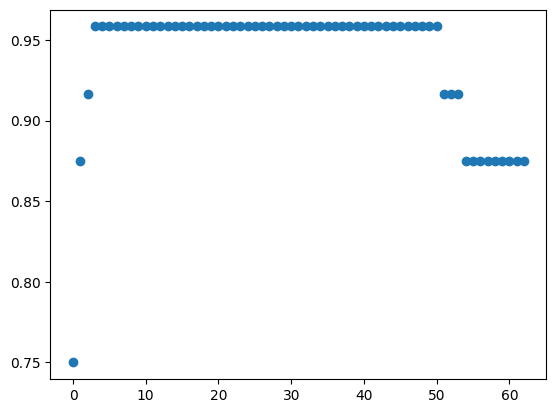

In [34]:
plt.scatter(range(len(scorelist)),scorelist)